(6, 388480)
(6, 388480)


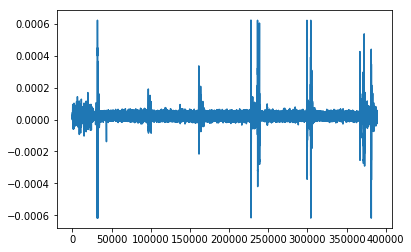

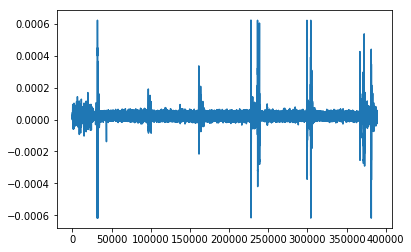

In [5]:
from preprocessor import DataSampleGenerator
from preprocessor import FeatureGenerator
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

sosHigh = signal.butter(20, 1, 'hp', fs=256, output='sos')
sosLow = signal.butter(20, 40, 'lp', fs=256, output='sos')

# ~~~~ SAMPLE CODE ~~~~

# Hz
offset = 0
# Hz
samplingRate = 256
# seconds
timeSegmentLen = 3
# overlap
overlap = 0
# seconds
labelSegmentLen = 3
# Hz
startCutoff = 0
endCutoff = 0

# Get the data from the matlab file
data = loadmat('data/BP_2019PP1.mat')['data'].T
# EEG data in following format: 
#   cols = samples, rows = channels
#   channels 6 and 7 contain bad data, so we ignore those
    
eeg = data[:6,:]
print(eeg.shape)
plt.plot(eeg[0])
plt.show()

for i, sig in enumerate(eeg):
    mean_removed = np.ones_like(sig)*np.mean(sig)
    sig = sig - mean_removed
    sig = signal.sosfilt(sosHigh, sig)
    eeg[i] = signal.sosfilt(sosLow, sig)
# Last 4 channels are the label channels
labels = data[8:12,:]

# Set up the sample generator:
#   samplingRate    : The current data file has a sampling rate of 256 Hz
#   timeSegmentLen  : We want to generate labeled samples of 3 seconds long
#   overlap         : We want to overlap each sample for two seconds
#   labelSegmentLen : The amount of seconds of data each corresponding to a label
#   startCutoff     : Amount of samples to ignore at the start of each labelSegment
#   endCutoff       : Amount of samples to ignore at the end of each labelSegment  
sampleGenerator = DataSampleGenerator(eeg, labels, samplingRate, timeSegmentLen, overlap,
                                        labelSegmentLen, startCutoff, endCutoff)

In [20]:
samples = {0: [], 1: [], 2: [], 3: []}
for sample, label in sampleGenerator:  
    samples[label].append(sample)

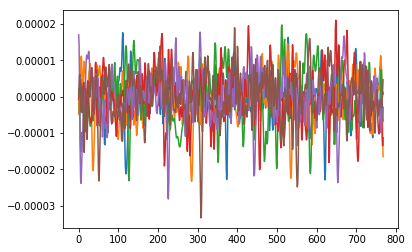

In [26]:
plt.plot(samples[0][0][0])
plt.plot(samples[0][1][0])
plt.plot(samples[0][2][0])
plt.plot(samples[0][3][0])
plt.plot(samples[0][4][0])
plt.plot(samples[0][5][0])
plt.show()

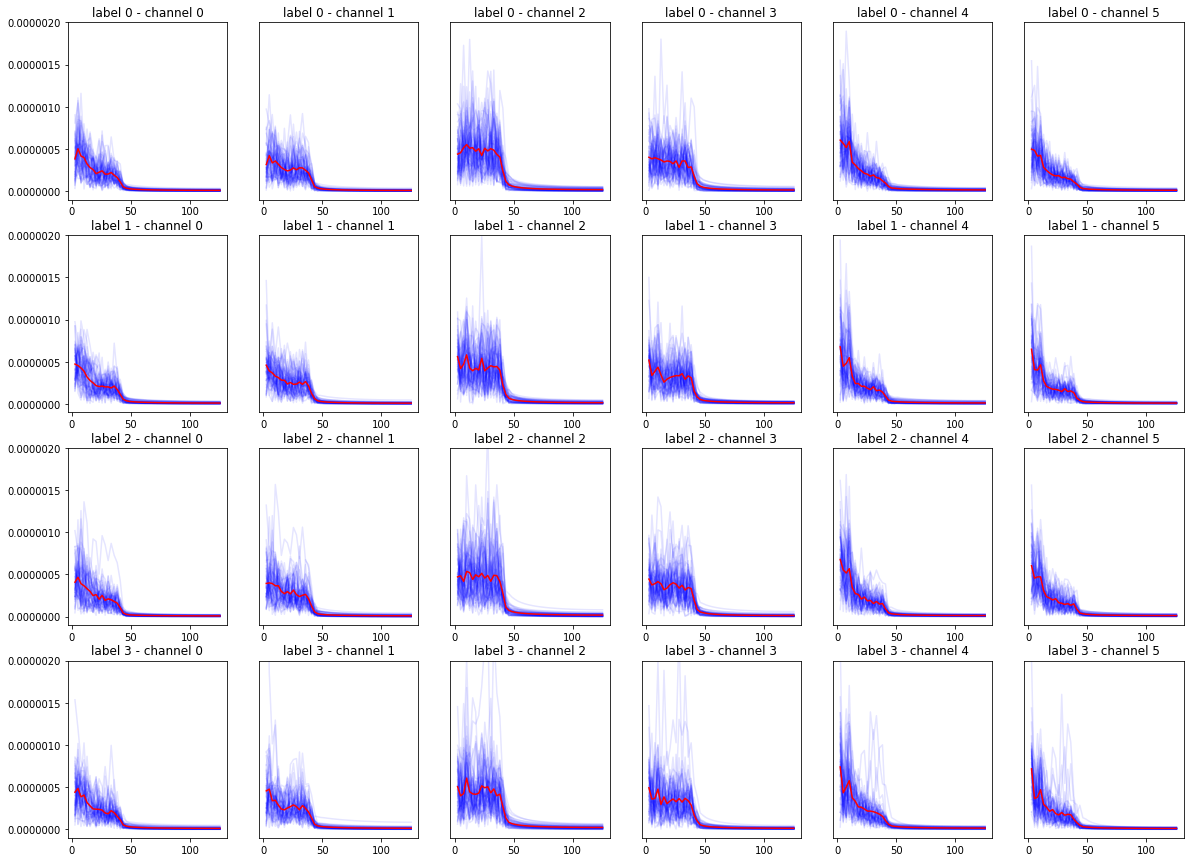

In [22]:
import scipy.fftpack
import numpy as np

channel = 0

fig, ax = plt.subplots(4, 6, figsize=(20, 15))
for j in range(6):
    for i in range(4):
        signal_avg = np.zeros((100,))
        data_avg = np.zeros((768,))
        ax[i][j].set_ylim([-0.0000001, 0.000002])
        for sample in samples[i]:
#             data_avg += sample[j]
#             ax[i][j].plot(sample[j], alpha=0.1, c='blue')
#         ax[i][j].set_title(f'label {i} - channel {j}')
#         ax[i][j].plot(data_avg / len(samples[i]), c='red')
#         data_avg = np.zeros((768,))
        
            y = sample[j]
            N = y.shape[0]           # Number of samplepoints
            Fs = samplingRate
            T = 1.0 / Fs      # N_samps*T (#samples x sample period) is the sample spacing.
            N_fft = 100        # Number of bins (chooses granularity)
            x = np.linspace(0, N*T, N)     # the interval

            yf = scipy.fftpack.fft(y,n=N_fft)
            xf = np.arange(0,Fs,Fs/N_fft)
            ax[i][j].plot(xf[1:50], 2.0/N * np.abs(yf[0:N//2])[1:50],alpha=0.1, c='blue')
            signal_avg += 2.0/N * np.abs(yf[0:N//2])
        signal_avg /= len(samples[i])
        ax[i][j].set_title(f'label {i} - channel {j}')
        ax[i][j].plot(xf[1:50], signal_avg[1:50], c='red')
        if j != 0:
            ax[i][j].set_yticks([], [])
plt.show()



In [6]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import scipy.fftpack

data = np.load('Klaas.npy', allow_pickle=True).T

print(data.shape)

pre_cue_channels = []
for channel in range(6):
    pre_cue_per_channel = []
    for entry in data:
        pre_cue = entry[channel][:26]
        pre_cue_per_channel.append(pre_cue)
    pre_cue_channels.append(np.average(pre_cue_per_channel))
    
ms1, ms2 = round(0.4*256), round(0.65*256)

accuracies = []

# Loop over all channels
option = 0
for j in range(6):
    # Loop again over channels
    for k in range(6):
        # 50?
        accuracy = 0
        for i in range(50):
            new_array = []
            for entry in data:
                if entry[-1] == 2 or entry[-1] == 3:
                    continue
                combination_channel = []
                y1 = entry[j][ms1:ms2] - pre_cue_channels[j]
                y2 = entry[k][ms1:ms2] - pre_cue_channels[k]
                        
                N = len(y1)           # Number of samplepoints
                Fs = 256
                T = 1.0 / Fs      # N_samps*T (#samples x sample period) is the sample spacing.
                N_fft = 100        # Number of bins (chooses granularity)

                y1f = scipy.fftpack.fft(y1,n=N_fft)
                y2f = scipy.fftpack.fft(y1,n=N_fft)
                y1 = 2.0/N * np.abs(y1f[0:N//2])[1:50]
                y2 = 2.0/N * np.abs(y2f[0:N//2])[1:50]
                
                
                combination_channel.extend(y1)
                combination_channel.extend(y2)
                combination_channel /= np.linalg.norm(combination_channel)
                
                new_array.append([list(combination_channel), entry[-1]])
                
            tempd = np.array(new_array)
            np.random.shuffle(tempd)
            test = np.array(tempd[:30])
            train = np.array(tempd[30:])
            
            Xt = train.T[0]
            Xf = test.T[0]
            
            Yt = train.T[1]
            Yf = test.T[1]
            
            clf = KNeighborsClassifier(n_neighbors=5)
            
            clf.fit(list(Xt), list(Yt))
            
            p = clf.predict(list(Xf))
            accuracy += np.sum(p == Yf) / len(p)
        print(f'Option: {option} - Ch1 = {j} Ch2 = {k} - Accuracy = {accuracy/50}')
        option += 1
        accuracies.append(accuracy / 50)
print(f'\nHighest accuracy - option: {accuracies.index(max(accuracies))} - accuracy {max(accuracies)}')
        
        
            
        
            
            
            
                
            

(199, 7)
Option: 0 - Ch1 = 0 Ch2 = 0 - Accuracy = 0.4986666666666665
Option: 1 - Ch1 = 0 Ch2 = 1 - Accuracy = 0.5060000000000001
Option: 2 - Ch1 = 0 Ch2 = 2 - Accuracy = 0.4733333333333333
Option: 3 - Ch1 = 0 Ch2 = 3 - Accuracy = 0.48
Option: 4 - Ch1 = 0 Ch2 = 4 - Accuracy = 0.48000000000000015
Option: 5 - Ch1 = 0 Ch2 = 5 - Accuracy = 0.4786666666666669
Option: 6 - Ch1 = 1 Ch2 = 0 - Accuracy = 0.558
Option: 7 - Ch1 = 1 Ch2 = 1 - Accuracy = 0.5593333333333333
Option: 8 - Ch1 = 1 Ch2 = 2 - Accuracy = 0.5539999999999999
Option: 9 - Ch1 = 1 Ch2 = 3 - Accuracy = 0.5340000000000003
Option: 10 - Ch1 = 1 Ch2 = 4 - Accuracy = 0.5779999999999998
Option: 11 - Ch1 = 1 Ch2 = 5 - Accuracy = 0.5346666666666667
Option: 12 - Ch1 = 2 Ch2 = 0 - Accuracy = 0.4386666666666666
Option: 13 - Ch1 = 2 Ch2 = 1 - Accuracy = 0.44666666666666677
Option: 14 - Ch1 = 2 Ch2 = 2 - Accuracy = 0.4366666666666666
Option: 15 - Ch1 = 2 Ch2 = 3 - Accuracy = 0.45066666666666655
Option: 16 - Ch1 = 2 Ch2 = 4 - Accuracy = 0.43
Op

In [115]:
from sklearn.neighbors import KNeighborsClassifier
import time

sampleGenerator = DataSampleGenerator(eeg, labels, samplingRate, timeSegmentLen, overlap,
                                        labelSegmentLen, startCutoff, endCutoff)

data = []
for sample, label in sampleGenerator:
    data.append((sample, label))

pre_cure_channels = []
for channel in range(6):
    pre_cure_per_channel = []
    for entry in data:
        pre_cure = entry[0][channel][:26]
        pre_cure_per_channel.append(pre_cure)
    pre_cure_channels.append(np.average(pre_cure_per_channel))
    
print(pre_cure_channels)
    
option = 1
accuracies = []
for ch1 in range(6):
    for ch2 in range(6):
        # avg
        accuracy = 0
        for i in range(50):
            features = []
            for sample, label in data:
                if label == 2 or label == 3:
                    label = 0
                feature = []
                feature.extend(sample[ch1][50:150] - pre_cure_channels[ch1])
                feature.extend(sample[ch2][50:150] - pre_cure_channels[ch2])
                feature /= np.linalg.norm(feature)
                features.append((feature, label))
            np.random.shuffle(features)
            train, test = features[:15], features[15:]
            Xtrain, Ytrain = list(zip(*train)) 
            Xtest, Ytest = list(zip(*test))
            
            clf = KNeighborsClassifier(n_neighbors=5)
            clf.fit(list(Xtrain), list(Ytrain))
            p = clf.predict(Xtest)
            accuracy += np.sum(p == Ytest) / len(p)
            
        print(f'Option: {option} - Ch1 = {ch1} Ch2 = {ch2} - Accuracy = {accuracy/50}')
        option += 1
        accuracies.append(accuracy / 50)

print(f'Max Accuracy: {max(accuracies)} - option: {accuracies.index(max(accuracies))}')
            
            
                

[1.703562321366739e-05, -2.6490267238293105e-05, -1.2185469743120235e-05, -8.949335645662036e-06, -1.0466071418091333e-05, 7.738719327898774e-06]
Option: 1 - Ch1 = 0 Ch2 = 0 - Accuracy = 0.6768648648648647
Option: 2 - Ch1 = 0 Ch2 = 1 - Accuracy = 0.682162162162162
Option: 3 - Ch1 = 0 Ch2 = 2 - Accuracy = 0.704216216216216
Option: 4 - Ch1 = 0 Ch2 = 3 - Accuracy = 0.7004324324324327
Option: 5 - Ch1 = 0 Ch2 = 4 - Accuracy = 0.6903783783783782
Option: 6 - Ch1 = 0 Ch2 = 5 - Accuracy = 0.6909189189189189
Option: 7 - Ch1 = 1 Ch2 = 0 - Accuracy = 0.6952432432432434
Option: 8 - Ch1 = 1 Ch2 = 1 - Accuracy = 0.706054054054054
Option: 9 - Ch1 = 1 Ch2 = 2 - Accuracy = 0.676108108108108
Option: 10 - Ch1 = 1 Ch2 = 3 - Accuracy = 0.6985945945945944
Option: 11 - Ch1 = 1 Ch2 = 4 - Accuracy = 0.6899459459459457
Option: 12 - Ch1 = 1 Ch2 = 5 - Accuracy = 0.6962162162162161
Option: 13 - Ch1 = 2 Ch2 = 0 - Accuracy = 0.6998918918918919
Option: 14 - Ch1 = 2 Ch2 = 1 - Accuracy = 0.7074594594594592
Option: 15 - 

100

(array([[ 2.25872263e-06,  2.33785122e-07, -1.21820937e-06, ...,
        -2.76119384e-06, -1.43564487e-08,  2.04588510e-06],
       [ 9.93557099e-07, -2.46084046e-06, -4.93834430e-06, ...,
        -2.69166891e-06, -2.22767613e-06, -8.00838546e-07],
       [ 1.18291389e-06,  5.64236225e-06,  9.63234686e-06, ...,
         6.68494079e-06, -4.21012746e-06, -1.44918829e-05],
       [-1.68695848e-06,  1.98924149e-06,  6.53262843e-06, ...,
        -6.37507178e-06, -5.76298385e-06, -4.21216979e-06],
       [ 2.80956564e-06,  6.48881542e-06,  1.07366810e-05, ...,
        -8.98200640e-06, -9.25370569e-06, -9.80524059e-06],
       [ 8.33126880e-07,  2.74844501e-06,  4.81328725e-06, ...,
        -9.68212535e-06, -1.11530243e-05, -1.16377836e-05]]), 2)
(array([[-4.40080193e-06, -1.54971761e-06,  2.22082798e-06, ...,
        -7.96991664e-06, -6.94510454e-06, -5.42195839e-06],
       [-5.30412899e-06, -5.94658625e-06, -5.00886400e-06, ...,
        -7.70777564e-06, -2.77392540e-06,  1.37281331e-06],
 

        -2.79511464e-06, -4.20252196e-06, -5.80848124e-06]]), 0)
(array([[ 9.41507692e-06,  8.10077043e-06,  7.50850973e-06, ...,
        -7.38755607e-07, -3.28928538e-06, -7.41965002e-06],
       [ 5.72543689e-06,  5.93499940e-06,  5.52172624e-06, ...,
         2.75791780e-06,  1.56624030e-06, -1.52091611e-06],
       [ 5.83349781e-06,  4.54533531e-06,  7.29198969e-06, ...,
        -1.08954073e-05, -8.45432355e-06, -5.60296337e-06],
       [ 1.20417894e-05,  1.09069949e-05,  1.10603765e-05, ...,
        -4.85432554e-06, -6.19916466e-06, -7.91084099e-06],
       [ 4.10394657e-06,  1.74629543e-06,  1.87286551e-06, ...,
        -1.37863496e-05, -1.24582768e-05, -1.04984465e-05],
       [ 7.91409850e-06,  7.32072387e-06,  7.98711790e-06, ...,
        -5.31352604e-06, -5.06495379e-06, -2.66887556e-06]]), 2)
(array([[-6.13567393e-07,  2.48107635e-06,  4.39031060e-06, ...,
         2.72855759e-06, -6.69394711e-07, -3.20819302e-06],
       [-3.10103334e-07,  3.93515251e-06,  6.98038873e-06, .

In [1]:
from preprocessor import DataSampleGenerator
from preprocessor import FeatureGenerator
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

sosHigh = signal.butter(20, 1, 'hp', fs=256, output='sos')
sosLow = signal.butter(20, 40, 'lp', fs=256, output='sos')

# ~~~~ SAMPLE CODE ~~~~

# Hz
offset = 0
# Hz
samplingRate = 256
# seconds
timeSegmentLen = 2
# overlap
overlap = 0
# seconds
labelSegmentLen = 3
# Hz
startCutoff = 0
endCutoff = 0

# Get the data from the matlab file
data = loadmat('data/BP_2019PP1.mat')['data'].T
# EEG data in following format: 
#   cols = samples, rows = channels
#   channels 6 and 7 contain bad data, so we ignore those
    
eeg = data[:6,:]
# for i, sig in enumerate(eeg):
#     mean_removed = np.ones_like(sig)*np.mean(sig)
#     sig = sig - mean_removed
#     sig = signal.sosfilt(sosHigh, sig)
#     eeg[i] = signal.sosfilt(sosLow, sig)
# Last 4 channels are the label channels
labels = data[8:12,:]


In [2]:
labels = fix_labels(labels)

NameError: name 'fix_labels' is not defined

In [ ]:
for l in labels:
    plt.plot(l[:50000])
plt.show()

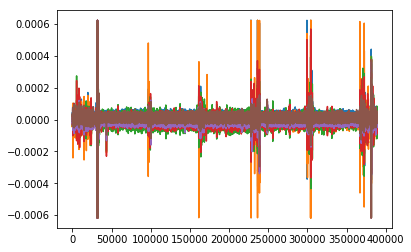

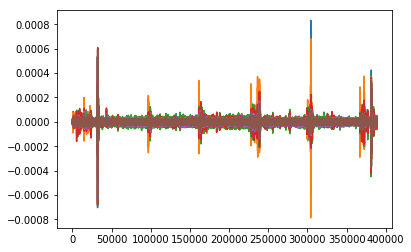

In [138]:
from sklearn.decomposition import FastICA

def fix_labels(labels):
        """
        Kenan's Magnum Opus (set all label channels to zero
        until it reaches a zero label)
        """
        for label in labels:
            i = 0
            while label[i] != 0:
                label[i] = 0
                i += 1
        return labels

segmentLen = 2
samplingRate = 256
preCue = 126


# Get the data from the matlab file
data = loadmat('data/BP_2019PP1.mat')['data'].T
# EEG data in following format: 
#   cols = samples, rows = channels
#   channels 6 and 7 contain bad data, so we ignore those
 
    
sosHigh = signal.butter(20, [0.1, 90], 'bp', fs=256, output='sos')
sosLow = signal.butter(20, [1, 50], 'bp', fs=256, output='sos')    

eeg = data[:6,:]
# for i, sig in enumerate(eeg):
#     mean_removed = np.ones_like(sig)*np.mean(sig)
#     sig = sig - mean_removed
#     sig = signal.sosfilt(sosHigh, sig)
#     eeg[i] = signal.sosfilt(sosLow, sig)
# Last 4 channels are the label channels
labels = data[8:12,:]

plt.plot(eeg[:,:].T)
plt.show()

for i in range(eeg.shape[0]):
    sig = eeg[i]
    mean_removed = np.ones_like(sig)*np.mean(sig)
    sig = sig - mean_removed
    sig = signal.sosfilt(sosLow, sig)
    eeg[i] = sig

plt.plot(eeg[:, :].T)
plt.show()

samples = []
sampleLabels = []
labels = fix_labels(labels).T



exportedSample = False
for i in range(labels.shape[0]):
    labelSample = labels[i,:]
    if np.any(labelSample):
        if exportedSample:
            continue
        #print(f'Found sample at {i / samplingRate} seconds with label {np.argmax(labelSample)}')
        sampleLabels.append(np.argmax(labelSample))
        samples.append(eeg[:,i - preCue:i + (segmentLen * samplingRate)])
        i += (segmentLen * samplingRate)
        exportedSample = True
    else:
        exportedSample = False

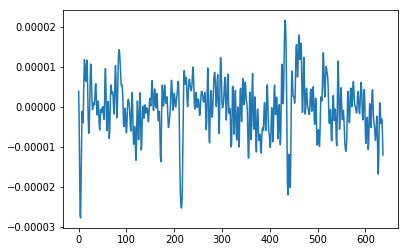

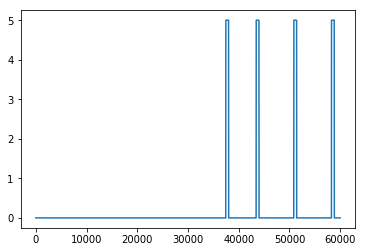

In [139]:
plt.plot(samples[0][0].T)
plt.show()
plt.plot(labels.T[2][:60000])

In [140]:
import scipy.fftpack
# Theta - Alpha - Beta - Gamma
bands = [(4, 8), (8, 16), (16, 32), (32, 90)]

featuresFFT = []
for sample in samples:
    feature = []
    for channel in sample:
        channelFeature = []
        N = len(channel)           # Number of samplepoints
        T = 1.0 / samplingRate      # N_samps*T (#samples x sample period) is the sample spacing.
        N_fft = 100        # Number of bins (chooses granularity)
        x = np.linspace(0, N*T, N)     # the interval

        yf = scipy.fftpack.fft(channel,n=N_fft)
        sampleFFT = 2.0/N * np.abs(yf[0:N//2])
        for band in bands:
            avgPower = sum(sampleFFT[band[0]:band[1]]) / len(sampleFFT[band[0]:band[1]])
            channelFeature.append(avgPower)
        feature.append(channelFeature)
    featuresFFT.append(feature)
        
for ch1 in range(1):
    for ch2 in range(1):
        accuracy = 0
        for i in range(1):
            features = []
            for sample, label in zip(featuresFFT, labelSample):
                if label == 2 or label == 3:
                    continue
                feature = []
                feature.extend(sample[ch1])
                feature.extend(sample[ch2])
                feature /= np.linalg.norm(feature)
                features.append((feature, label))
            np.random.shuffle(features)
            train, test = features[15:], features[:15]
            Xtrain, Ytrain = list(zip(*train))[0], list(zip(*train))[1]
            print(Xtrain)
            Xtest, Ytest = list(zip(*test))
            
            clf = KNeighborsClassifier(n_neighbors=5)
            clf.fit(list(Xtrain), list(Ytrain))
            p = clf.predict(Xtest)
            accuracy += np.sum(p == Ytest) / len(p)
            
        print(f'Option: {option} - Ch1 = {ch1} Ch2 = {ch2} - Accuracy = {accuracy/50}')
        option += 1
        accuracies.append(accuracy / 50)

print(f'Max Accuracy: {max(accuracies)} - option: {accuracies.index(max(accuracies))}')

IndexError: list index out of range

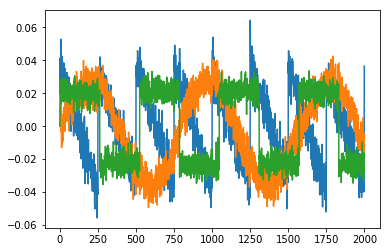